# Results from WandB


## Imports

In [2]:
import wandb
from community.utils.wandb_utils import get_wandb_artifact, get_wandb_runs
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
import json
import seaborn as sns
import pandas as pd


## Load Results

In [3]:
sweep_path = "gbena/funcspec/mjw4dzu9"
sweep_path = "m2snn/funcspec_V2/1ldo81ej"

sweep_id = sweep_path.split("/")[-1]

total_data = pd.read_pickle(f"../../results/sweep_tables/{sweep_id}")
total_data.columns, total_data.shape

(Index(['Step', 'best_acc', 'n_hidden', 'sparsity', 'mean_corr_det',
        'mean_corr_norm_1', 'mean_corr_norm_2', 'mean_corr_norm_fro',
        'mean_corr_norm_nuc', 'mean_corr_global_diff', 'bottleneck_det',
        'bottleneck_norm_1', 'bottleneck_norm_2', 'bottleneck_norm_fro',
        'bottleneck_norm_nuc', 'bottleneck_global_diff', 'name'],
       dtype='object'),
 (127250, 17))

## Plot Smooth Heatmap

In [4]:
filtered_data = total_data[(total_data["Step"] == 1)]
filtered_data.shape

(63625, 17)

In [5]:
y_values, x_values, z_values_diff, z_values_det = filtered_data[
    ["sparsity", "n_hidden", "bottleneck_global_diff", "bottleneck_det"]
].values.T

norms = {str(norm) : filtered_data[f"bottleneck_norm_{norm}"].values for norm in [1, 2, 'fro', 'nuc'] }

values_diff = x_values, y_values, z_values_diff

In [6]:
def gaussian_filter(x, y, sigmas):

    eps = 1e-10
    filter = np.exp(-((x / sigmas[0]) ** 2 + (y / sigmas[1]) ** 2))

    return filter

def filter_nans(values) : 
    idxs = np.isnan(values[-1])
    return [v[~idxs] for v in values]

def weighted_average(x, y, sigmas, values):

    x_values, y_values, z_values = values

    return (
        (z_values * gaussian_filter(x - x_values, y - y_values, sigmas))
    ).sum() / gaussian_filter(x - x_values, y - y_values, sigmas).sum()


def plot_filters(sigmas, values):
    x_values, y_values, z_values = values

    Y = np.linspace(y_values.min(), y_values.max(), 100)
    X = np.linspace(x_values.min(), x_values.max(), 100)

    points = [10, 50, 90]

    fig, axs = plt.subplots(1, len(points), figsize=(10, 5))
    for p, ax in zip(points, axs):

        point = [X[p], Y[p]]
        filter = lambda x, y: gaussian_filter(
            (x - point[0]), y - point[1], sigmas=sigmas
        ).sum()

        Z = np.array([[filter(x, y) for x in X] for y in Y])
        sns.heatmap(Z, ax=ax)


def movingaverage(interval, window_size):
    window = np.ones(int(window_size)) / float(window_size)
    return np.convolve(interval, window, "same")


def compute_and_plot(values, log_scale=False, plot=False, random=True):

    x_values, y_values, z_values = filter_nans(values)

    if random : 
        idxs = np.arange(len(x_values))
        np.random.shuffle(idxs)
        idxs = idxs[ : len(idxs) // 5]
        values = x_values, y_values, z_values =  x_values[idxs], y_values[idxs], z_values[idxs]

    smoothness = 4
    resolution = 300

    if log_scale:
        X = np.linspace(x_values.min(), x_values.max(), resolution)
        Y = np.linspace(
            y_values.min(), y_values.max(), resolution
        )  # 500 x 500 takes 10s
    else:
        X = np.geomspace(x_values.min(), x_values.max(), resolution)
        Y = np.geomspace(y_values.min(), y_values.max(), resolution)
        # print(Y)

    Xm, Ym = np.meshgrid(X, Y)

    ratio = y_values / x_values
    ratio = movingaverage(ratio, len(ratio)// 3)
    sigmas = np.array([np.ones_like(ratio), ratio * 3 ]) * smoothness

    ratio = (y_values / x_values).mean()
    sigmas = np.array([1, 3*ratio ]) * smoothness

    vect_avg = np.vectorize(
        lambda x, y: weighted_average(x, y, sigmas, values), signature=("(),()->()")
    )
    Z = vect_avg(Xm, Ym)

    if plot:
        plot_filters(sigmas, values)

    plt.figure(figsize=(20, 10))
    plt.pcolormesh(X, Y, Z, cmap="viridis")
    if log_scale:

        """"""
        #plt.xscale("log")
        plt.yscale("log")

    plt.ylim(y_values.min(), y_values.max())
    plt.xlim(x_values.min(), x_values.max())

    # plt.grid(True)
    plt.colorbar()

    return (X, Y), (Xm, Ym), Z, sigmas

## heatmap

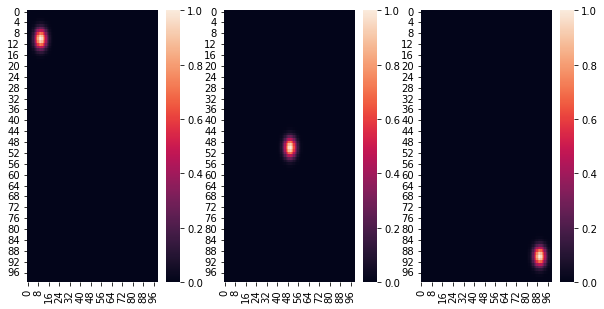

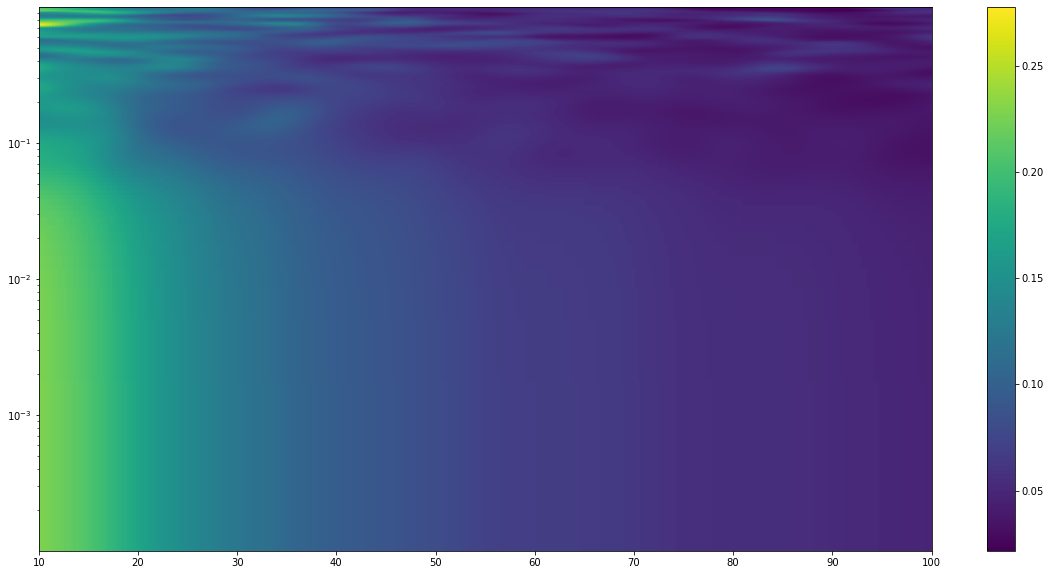

In [45]:
(X, Y), (X_mesh, Y_mesh), Z_diff, sigmas = compute_and_plot(
    values_diff, True, True
)

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

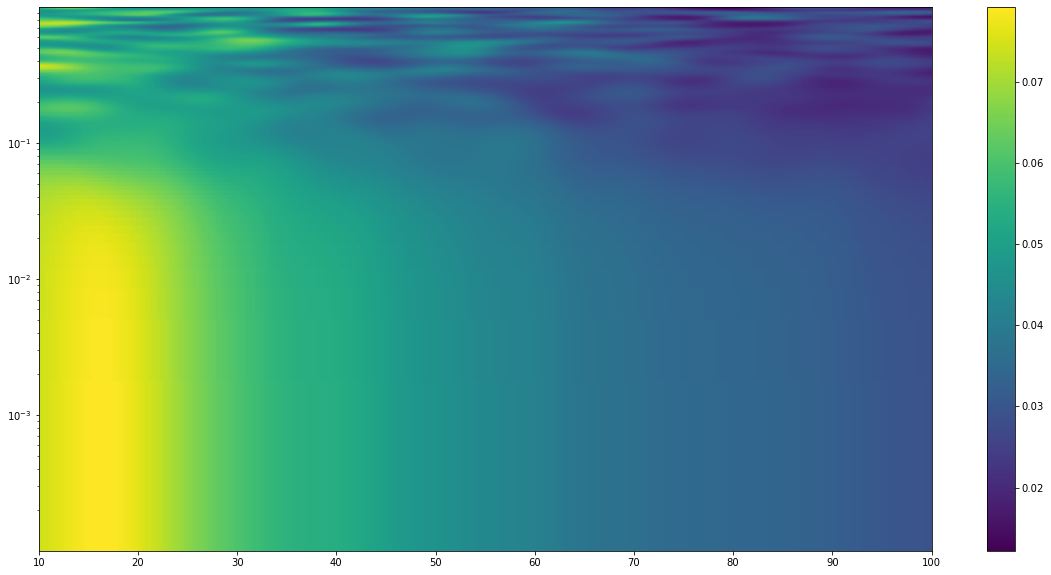

In [60]:
for i, norm in enumerate(norms.values()) : 
    
    plt.figure(i)
    
    values_det = x_values, y_values, z_values_det / norm

    X, Y, Z_det, sigmas = compute_and_plot(values_det, True, False)

In [51]:
norm.shape

(1, 63625)

# Scipy

In [7]:
from scipy.interpolate import griddata as gd

In [22]:
resolution = 1000
log_scale = True

if log_scale:
    X = np.linspace(x_values.min(), x_values.max(), resolution)
    Y = np.linspace(
        y_values.min(), y_values.max(), resolution
    )  # 500 x 500 takes 10s
else:
    X = np.geomspace(x_values.min(), x_values.max(), resolution)
    Y = np.geomspace(y_values.min(), y_values.max(), resolution)
    # print(Y)

X_mesh, Y_mesh = np.meshgrid(X, Y)

Z = gd((x_values, y_values), z_values_diff, (X_mesh, Y_mesh), method='nearest', rescale=True)

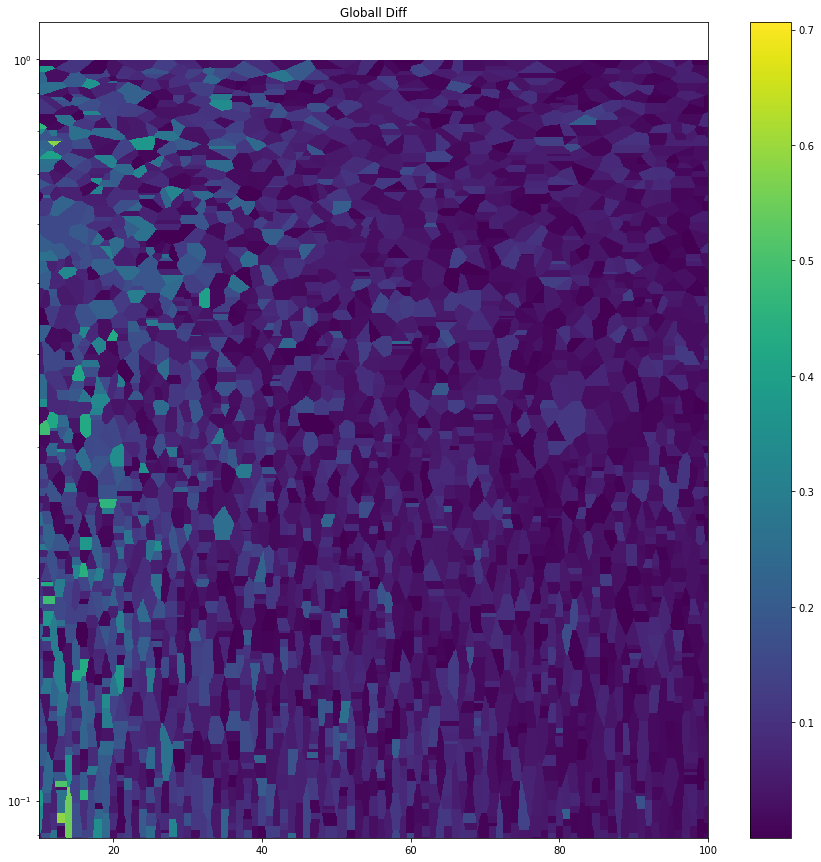

In [24]:
plt.figure(figsize = (15, 15))
plt.pcolormesh(X_mesh, Y_mesh, Z, cmap="viridis")

#plt.imshow(Z)
if log_scale:

    #plt.xscale("log")
    plt.yscale("log")

#plt.ylim(y_values.min(), y_values.max())
#plt.xlim(x_values.min(), x_values.max())

# plt.grid(True)
plt.title('Globall Diff')
plt.colorbar()

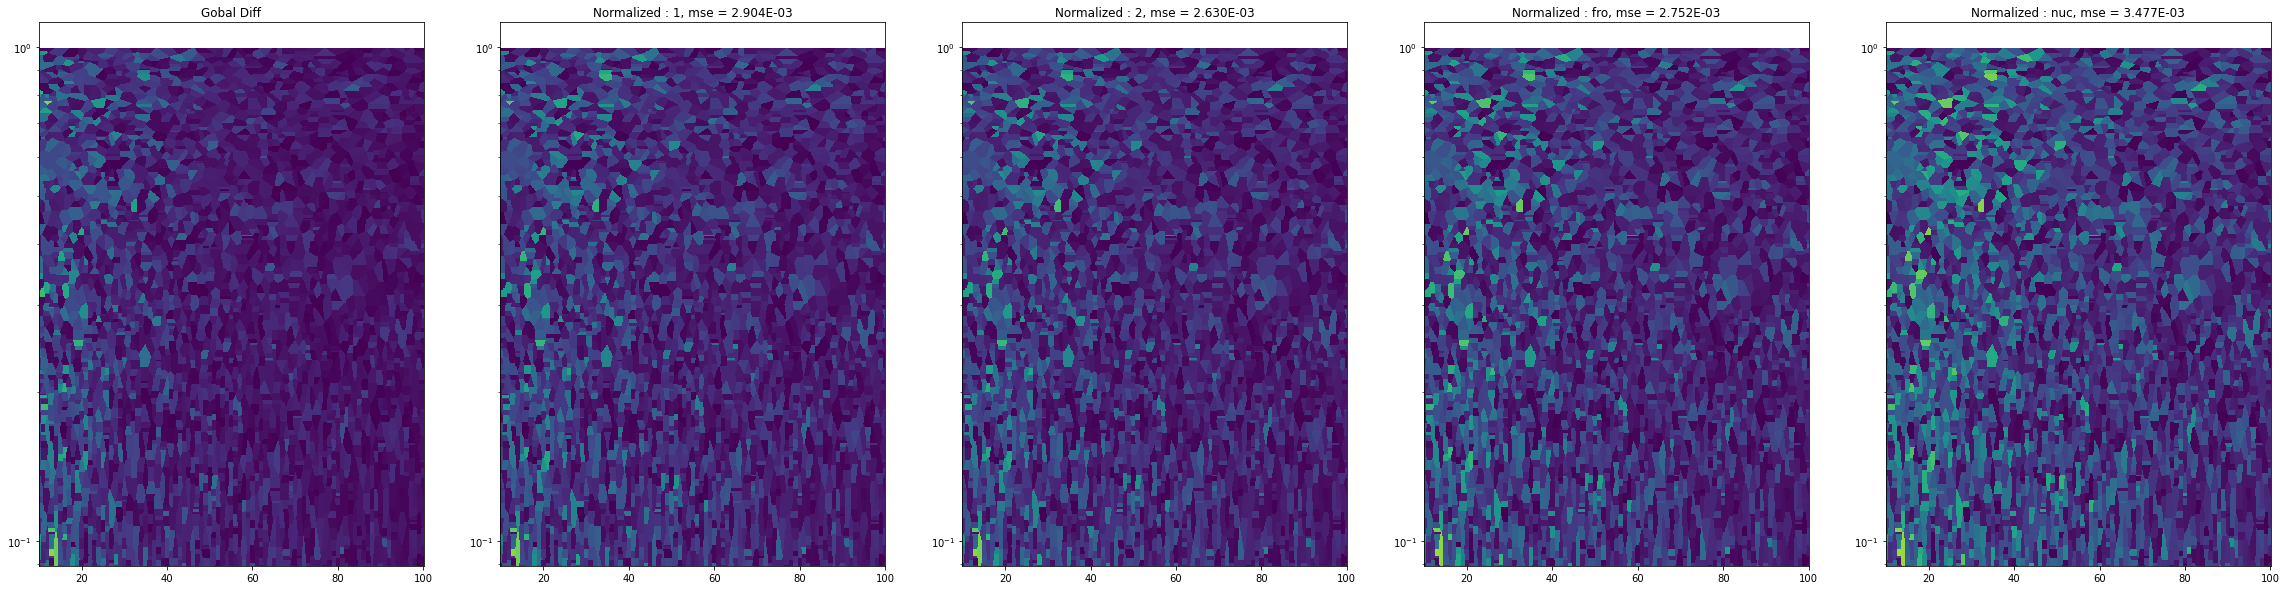

In [27]:
fig, axs = plt.subplots(1, len(norms) + 1, figsize=(40, 10))

Zs = []

ax = axs[0]

Z = gd((x_values, y_values), z_values_diff, (X_mesh, Y_mesh), method='nearest', rescale=True)
ax.pcolormesh(X_mesh, Y_mesh, Z, cmap="viridis")

Zs.append(Z)

if log_scale:

    #plt.xscale("log")
    ax.set_yscale("log")

#plt.ylim(y_values.min(), y_values.max())
#plt.xlim(x_values.min(), x_values.max())

# plt.grid(True)
ax.set_title(f'Gobal Diff')

for i, (ax, norm) in enumerate(zip(axs[1:], norms.items())) : 

    Z = gd((x_values, y_values), z_values_det / norm[1], (X_mesh, Y_mesh), method='nearest', rescale=True)
    ax.pcolormesh(X_mesh, Y_mesh, Z, cmap="viridis")

    #plt.imshow(Z)
    if log_scale:

        #plt.xscale("log")
        ax.set_yscale("log")

    #plt.ylim(y_values.min(), y_values.max())
    #plt.xlim(x_values.min(), x_values.max())

    # plt.grid(True)
    ax.set_title(f'Normalized : {norm[0]}, mse = {((Zs[0] - Z) ** 2).mean() :.3E}')
    Zs.append(Z)

fig.show()


In [21]:
Zs[0]

array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [0.12865786, 0.13249865, 0.13633943, ..., 0.02906523, 0.02685999,
        0.02465476],
       [0.41673348, 0.35764096, 0.29854844, ..., 0.04601754, 0.04871633,
        0.05141512],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])

In [18]:
mse  = lambda x, y : ((x - y) ** 2).mean()

Z_mses = np.array([[mse(Z1, Z2) for Z1 in Zs] for Z2 in Zs])

In [19]:
Z_mses

array([[nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan]])

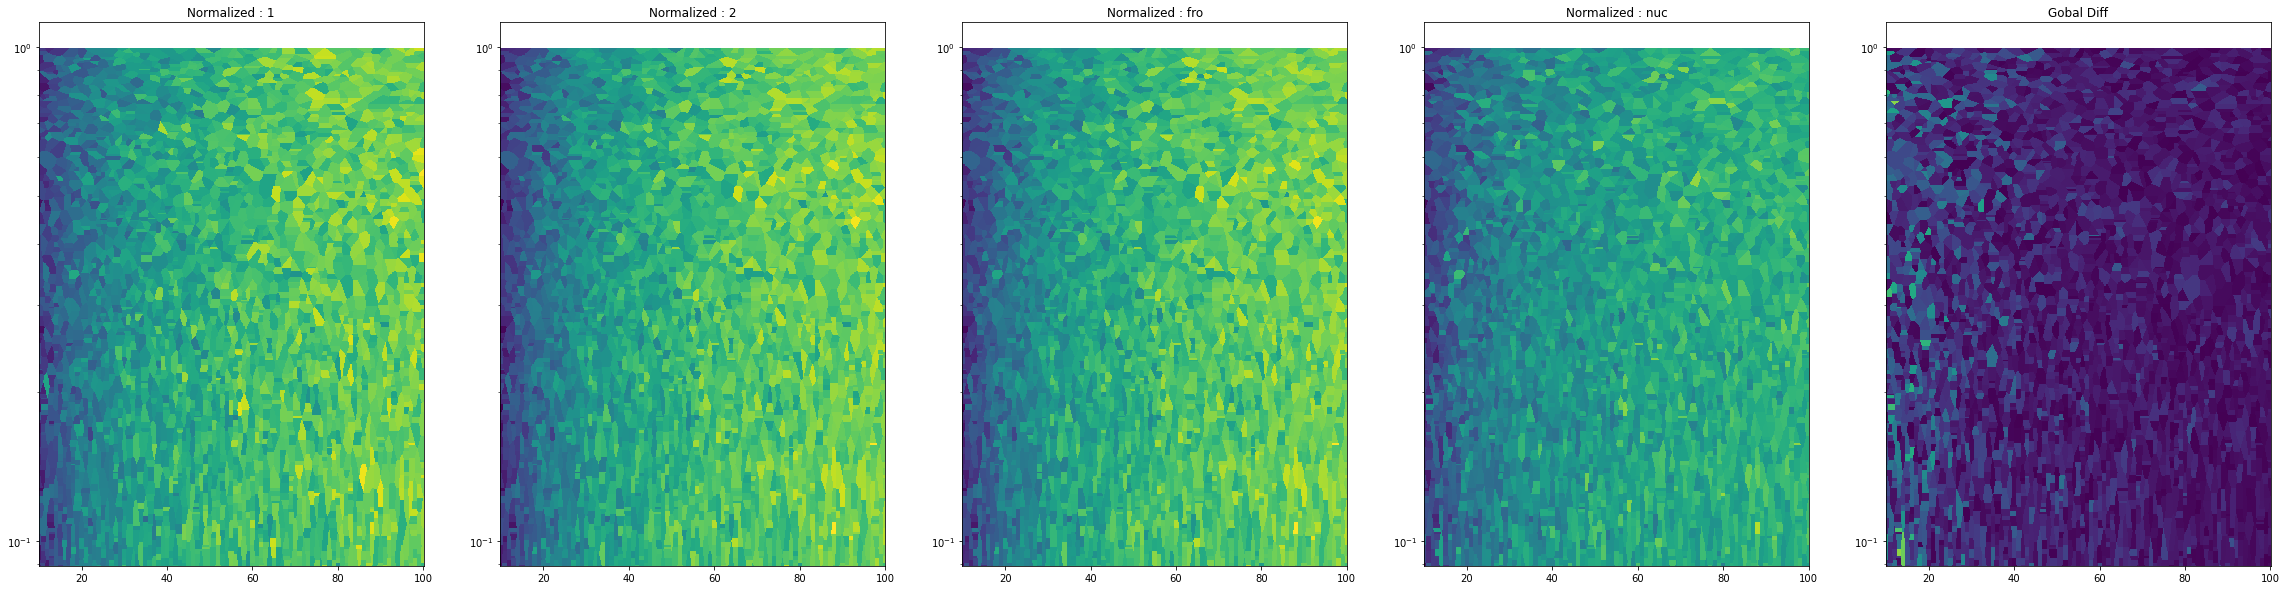

In [13]:
fig, axs = plt.subplots(1, len(norms) + 1, figsize=(40, 10))

Zs = []

for i, (ax, norm) in enumerate(zip(axs, norms.items())) : 

    Z = gd((x_values, y_values), norm[1], (X_mesh, Y_mesh), method='nearest', rescale=True)
    ax.pcolormesh(X_mesh, Y_mesh, Z, cmap="viridis")

    #plt.imshow(Z)
    if log_scale:

        #plt.xscale("log")
        ax.set_yscale("log")

    #plt.ylim(y_values.min(), y_values.max())
    #plt.xlim(x_values.min(), x_values.max())

    # plt.grid(True)
    ax.set_title(f'Normalized : {norm[0]}')
    Zs.append(Z)

ax = axs[-1]

Z = gd((x_values, y_values), z_values_diff, (X_mesh, Y_mesh), method='nearest', rescale=True)
ax.pcolormesh(X_mesh, Y_mesh, Z, cmap="viridis")

if log_scale:

    #plt.xscale("log")
    ax.set_yscale("log")

#plt.ylim(y_values.min(), y_values.max())
#plt.xlim(x_values.min(), x_values.max())

# plt.grid(True)
ax.set_title(f'Gobal Diff')
Zs.append(Z)

fig.show()
